In [37]:
import numpy as np
import copy

from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [46]:
transform = {"train": T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.4914, 0.44822, 0.4465], [0.247, 0.243, 0.261]),
                        T.RandomCrop(32, 4),
                        T.RandomRotation(10)
                      ]),
             "test": T.Compose([
                        T.ToTensor(),
                        T.Normalize([0.4914, 0.44822, 0.4465], [0.247, 0.243, 0.261])
                      ])}

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform["train"])
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform["test"])

Files already downloaded and verified
Files already downloaded and verified


In [47]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=False, num_workers=12)
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=128, shuffle=False, num_workers=12)
loader_test = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=False, num_workers=12)

In [48]:
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()

        self.conv = nn.Sequential(
            
            # Layer set 1 - half ones - scaledown: 2 * 2
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Layer set 2 - half twice - scaledown: 2 * 2
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Layer set 3 - half third - scaledown: 2 * 2
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )

        self.linear = nn.Sequential(

            nn.Linear(4096, 1024),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout2d(0.2),

            nn.Linear(512, 10),
        )

    def forward(self, x):

        # Conv layer
        x = self.conv(x)

        # View 
        x = x.view(x.size(0), -1)

        # Linear layer
        logits = self.linear(x)

        return logits

In [49]:
best_accuracy = 0
best_model = None

device = torch.device('cuda')

model = ConvNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

early_stoppin = 0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in tqdm(range(50)):

    # Training set

    model.train()

    epoch_losses = []
    correct, total = 0, 0

    for x, y in loader_train:
        
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        yhat = F.log_softmax(logits, dim=1)
        loss = F.nll_loss(yhat, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()

    train_loss = np.mean(epoch_losses)
    train_accuracy = correct / total

    #  Validation set

    with torch.no_grad():

        model.eval()

        valid_losses_batch = []
        correct, total = 0, 0

        for x, y in loader_valid:

            x, y = x.to(device), y.to(device)
            logits = model(x)
            yhat = F.log_softmax(logits, dim=1)
            loss = F.nll_loss(yhat, y)

            total += len(x)
            valid_losses_batch.append(loss.item())
            correct += (torch.argmax(logits, dim=1) == y).sum().item()
    
    valid_loss = np.mean(valid_losses_batch)
    valid_accuracy = correct/total

    # Save the best model

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_model = copy.deepcopy(model), epoch
        early_stoppin = 0
    else:
        early_stoppin += 1

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    scheduler.step()

    if early_stoppin > 10:
        break

100%|██████████| 50/50 [06:13<00:00,  7.47s/it]


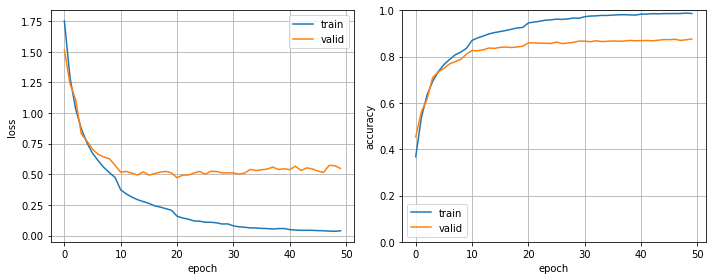

In [51]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(valid_accuracies, label='valid')
plt.ylim(0, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
model = best_model[0]

with torch.no_grad():

    correct, total = 0, 0
    model.eval()

    for x, y in loader_test:

      x, y = x.to(device), y.to(device)
      logits = model(x)
      log_probs = F.log_softmax(logits, dim=1)
      loss = F.nll_loss(log_probs, y)

      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    
valid_accuracy = correct/total

print("The test accuracy: %s"%(valid_accuracy))